# 階層クラスタリング

参考
- オライリー書籍「実践　時系列解析」
- https://datawokagaku.com/hierarchical_clustering/

In [1]:
import os
import numpy as np
import pandas as pd
import japanize_matplotlib
import matplotlib.pyplot as plt

In [33]:
from sklearn.metrics import pairwise_distances
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram 
from sklearn.cluster import AgglomerativeClustering

In [3]:
# -1〜+1の間に規格化 :ToDo
def normalize(score):
    norm = (score-score.min())/(score.max()-score.min()) # 0-1に規格化
    norm = norm * 2
    norm = norm - np.mean(norm, axis=0)
    return norm

In [4]:
# オライリー「実践時系列解析」に掲載のコード
def distDTW(ts1, ts2):
    # 設定部分
    DTW = {}
    for i in range(len(ts1)):
        DTW[i, -1] = np.inf
    for i in range(len(ts2)):
        DTW[-1, i] = np.inf
    DTW[(-1, -1)] = 0

    # 1ステップずつ，最適な対応付を計算する部分
    for i in range(len(ts1)):
        for j in range(len(ts2)):
            dist = (ts1[i] - ts2[j]) ** 2
            DTW[(i, j)] = dist + min(DTW[i-1, j], DTW[(i, j-1)], DTW[(i-1, j-1)])
    
    # 完全な経路が見つかったら関連する距離を返す
    return np.sqrt(DTW[len(ts1)-1, len(ts2)-1])

In [5]:
# 使うデータは1036冊分の小説データの感情スコア値
SCORE_PATH = 'data/all_score_0630.csv'
TARGET_PATH = 'data/target2.csv'

In [6]:
# スコアファイル読み込み
score_df = pd.read_csv(SCORE_PATH, index_col=0)
score_df.head()

,S00,S01,S02,S03,S04,S05,S06,S07,S08,S09,...,S90,S91,S92,S93,S94,S95,S96,S97,S98,S99
13,0.791536,0.737968,0.829343,0.794293,0.724665,0.707668,0.620669,0.607199,0.584499,0.626389,...,0.754139,0.782878,0.784226,0.576965,0.534152,0.601299,0.612696,0.611167,0.664706,0.736535
24,0.749562,0.727724,0.721075,0.648729,0.764811,0.627247,0.634754,0.640822,0.792777,0.844474,...,0.690379,0.640809,0.828280,0.806064,0.754045,0.906671,0.896347,0.869153,0.901117,0.933473
30,0.473785,0.473785,0.652944,0.622040,0.663769,0.799352,0.982744,0.966812,0.851591,0.907304,...,0.101549,0.142406,0.285570,0.270750,0.320434,0.441094,0.464494,0.548101,0.610829,0.517892
41,0.900899,0.952689,1.000000,0.928408,0.802310,0.760143,0.699925,0.759109,0.660739,0.726829,...,0.094422,0.246499,0.291265,0.373439,0.445357,0.450839,0.390509,0.337263,0.402609,0.459209
47,0.742317,0.836033,0.890097,0.911625,0.967501,0.967501,0.972570,0.982321,1.000000,0.929571,...,0.202141,0.256933,0.256933,0.243298,0.175068,0.204548,0.171354,0.173879,0.108680,0.023454


In [7]:
# ターゲットファイル読み込み
target_df = pd.read_csv(TARGET_PATH, index_col=0)
target_df.head(2)

,対象,人物ID,氏名,読み,作品ID,作品名,副題,作品名読み,図書カードURL,テキストファイルURL,テキストファイルパス,スコアファイルパス,備考,length
0,True,374,饗庭 篁村,あえば こうそん,45754,良夜,NaN,りょうや,https://www.aozora.gr.jp/cards/000374/card4575...,https://www.aozora.gr.jp/cards/000374/files/45...,./bunko/cards/000374/files/edit/45754_ruby_236...,./bunko/cards/000374/files/score/45754_ruby_23...,NaN,119.0
1,True,879,芥川 竜之介,あくたがわ りゅうのすけ,73,或敵打の話,NaN,あるかたきうちのはなし,https://www.aozora.gr.jp/cards/000879/card73.html,https://www.aozora.gr.jp/cards/000879/files/73...,./bunko/cards/000879/files/edit/73_ruby_1217.txt,./bunko/cards/000879/files/score/73_ruby_1217.txt,NaN,280.0


In [8]:
# ターゲットファイルとスコアファイルをマージ
df_merge_all = pd.merge(target_df, score_df, left_index=True, right_index=True)
df_merge_all.head(2)

,対象,人物ID,氏名,読み,作品ID,作品名,副題,作品名読み,図書カードURL,テキストファイルURL,...,S90,S91,S92,S93,S94,S95,S96,S97,S98,S99
13,True,879,芥川 竜之介,あくたがわ りゅうのすけ,124,お律と子等と,NaN,おりつとこらと,https://www.aozora.gr.jp/cards/000879/card124....,https://www.aozora.gr.jp/cards/000879/files/12...,...,0.754139,0.782878,0.784226,0.576965,0.534152,0.601299,0.612696,0.611167,0.664706,0.736535
24,True,879,芥川 竜之介,あくたがわ りゅうのすけ,77,奇怪な再会,NaN,きかいなさいかい,https://www.aozora.gr.jp/cards/000879/card77.html,https://www.aozora.gr.jp/cards/000879/files/77...,...,0.690379,0.640809,0.828280,0.806064,0.754045,0.906671,0.896347,0.869153,0.901117,0.933473


In [9]:
# Indexを列として出して，振り直し
df_merge = df_merge_all.reset_index()
df_merge = df_merge.rename(columns={'index': 'TargetID'})
df_merge.head()

,TargetID,対象,人物ID,氏名,読み,作品ID,作品名,副題,作品名読み,図書カードURL,...,S90,S91,S92,S93,S94,S95,S96,S97,S98,S99
0,13,True,879,芥川 竜之介,あくたがわ りゅうのすけ,124,お律と子等と,NaN,おりつとこらと,https://www.aozora.gr.jp/cards/000879/card124....,...,0.754139,0.782878,0.784226,0.576965,0.534152,0.601299,0.612696,0.611167,0.664706,0.736535
1,24,True,879,芥川 竜之介,あくたがわ りゅうのすけ,77,奇怪な再会,NaN,きかいなさいかい,https://www.aozora.gr.jp/cards/000879/card77.html,...,0.690379,0.640809,0.828280,0.806064,0.754045,0.906671,0.896347,0.869153,0.901117,0.933473
2,30,True,879,芥川 竜之介,あくたがわ りゅうのすけ,38,戯作三昧,NaN,げさくざんまい,https://www.aozora.gr.jp/cards/000879/card38.html,...,0.101549,0.142406,0.285570,0.270750,0.320434,0.441094,0.464494,0.548101,0.610829,0.517892
3,41,True,879,芥川 竜之介,あくたがわ りゅうのすけ,59,邪宗門,NaN,じゃしゅうもん,https://www.aozora.gr.jp/cards/000879/card59.html,...,0.094422,0.246499,0.291265,0.373439,0.445357,0.450839,0.390509,0.337263,0.402609,0.459209
4,47,True,879,芥川 竜之介,あくたがわ りゅうのすけ,155,少年,NaN,しょうねん,https://www.aozora.gr.jp/cards/000879/card155....,...,0.202141,0.256933,0.256933,0.243298,0.175068,0.204548,0.171354,0.173879,0.108680,0.023454


In [10]:
# スコアだけ表示してみる
df_merge.loc[:,'S00':]

,S00,S01,S02,S03,S04,S05,S06,S07,S08,S09,...,S90,S91,S92,S93,S94,S95,S96,S97,S98,S99
0,0.791536,0.737968,0.829343,0.794293,0.724665,0.707668,0.620669,0.607199,0.584499,0.626389,...,0.754139,0.782878,0.784226,0.576965,0.534152,0.601299,0.612696,0.611167,0.664706,0.736535
1,0.749562,0.727724,0.721075,0.648729,0.764811,0.627247,0.634754,0.640822,0.792777,0.844474,...,0.690379,0.640809,0.828280,0.806064,0.754045,0.906671,0.896347,0.869153,0.901117,0.933473
2,0.473785,0.473785,0.652944,0.622040,0.663769,0.799352,0.982744,0.966812,0.851591,0.907304,...,0.101549,0.142406,0.285570,0.270750,0.320434,0.441094,0.464494,0.548101,0.610829,0.517892
3,0.900899,0.952689,1.000000,0.928408,0.802310,0.760143,0.699925,0.759109,0.660739,0.726829,...,0.094422,0.246499,0.291265,0.373439,0.445357,0.450839,0.390509,0.337263,0.402609,0.459209
4,0.742317,0.836033,0.890097,0.911625,0.967501,0.967501,0.972570,0.982321,1.000000,0.929571,...,0.202141,0.256933,0.256933,0.243298,0.175068,0.204548,0.171354,0.173879,0.108680,0.023454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1031,1.000000,0.886321,0.760418,0.683147,0.649745,0.606923,0.571151,0.517130,0.492479,0.494035,...,0.180267,0.172682,0.146108,0.091107,0.070645,0.042570,0.032390,0.094500,0.142480,0.098496
1032,0.928336,1.000000,0.946976,0.868300,0.888023,0.706569,0.560303,0.661318,0.782652,0.888690,...,0.472828,0.545340,0.500948,0.563695,0.563695,0.697739,0.767883,0.759698,0.974234,0.763724
1033,1.000000,0.909603,0.793596,0.745868,0.727928,0.758194,0.740752,0.763606,0.817574,0.829033,...,0.687817,0.752808,0.738397,0.750526,0.830493,0.896725,0.919508,0.899834,0.873144,0.925176
1034,0.528431,0.438392,0.438334,0.539294,0.604325,0.652928,0.757941,0.918232,0.951555,0.909684,...,0.440108,0.449598,0.485174,0.381715,0.325619,0.357203,0.409554,0.360593,0.315495,0.401312


In [11]:
scores = df_merge.loc[:,'S00':].to_numpy()
# scores = score_df.to_numpy()

In [12]:
# 平均値を０にしておく(-1〜1の間に規格化)
A = normalize(scores)
# A = scores - scores.mean(axis=0)
A.shape, np.min(A), np.max(A), np.mean(A)

((1036, 100), -1.1071332471188664, 1.0698986010803475, -4.020807710804621e-18)

## ペアワイズ距離行列を取得

In [14]:
# DTWを使ってペアワイズ距離行列を計算
p = pairwise_distances(A, metric=distDTW)
with open('data/pairwise_word_distances.npy', 'wb') as f:
    np.save(f, p)

In [13]:
# 保存された行列を読み込む
p = np.load('data/pairwise_word_distances.npy')

In [14]:
p.shape

(1036, 1036)

## 階層クラスタリング実施

In [27]:
Z = linkage(p, 'ward')
Z.shape

/tmp/ipykernel_2039618/154936015.py:1: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(p, 'ward')


(1035, 4)

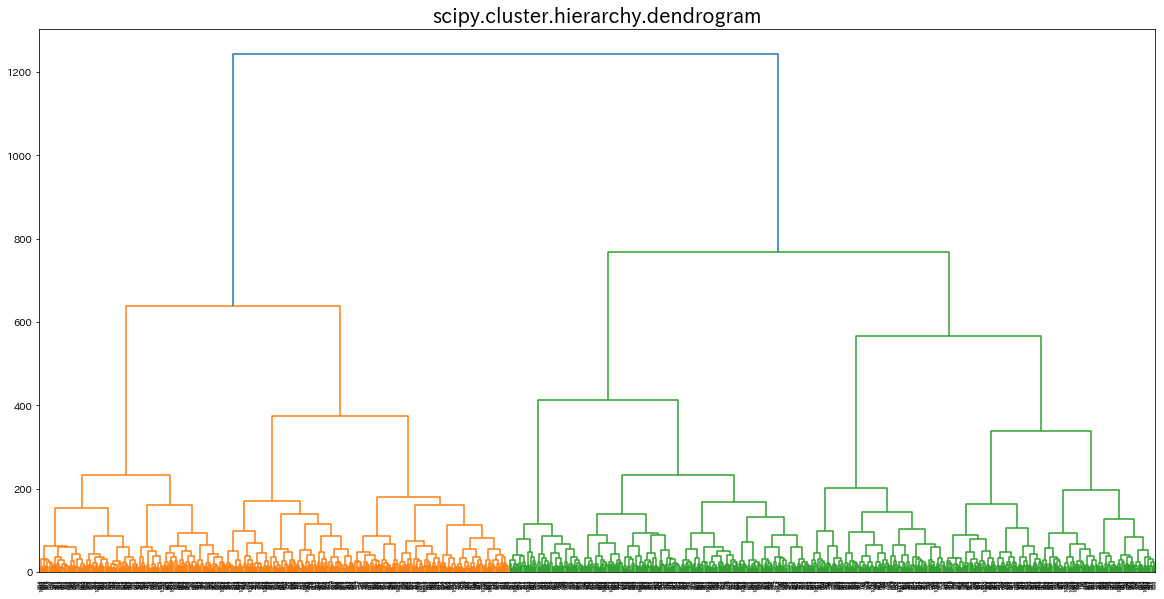

In [29]:
# dendrogram描画
plt.figure(figsize=(20, 10))
plt.title('scipy.cluster.hierarchy.dendrogram', fontsize=20)
d = dendrogram(Z)
# d = dendrogram(Z, truncate_mode='lastp', p=8)

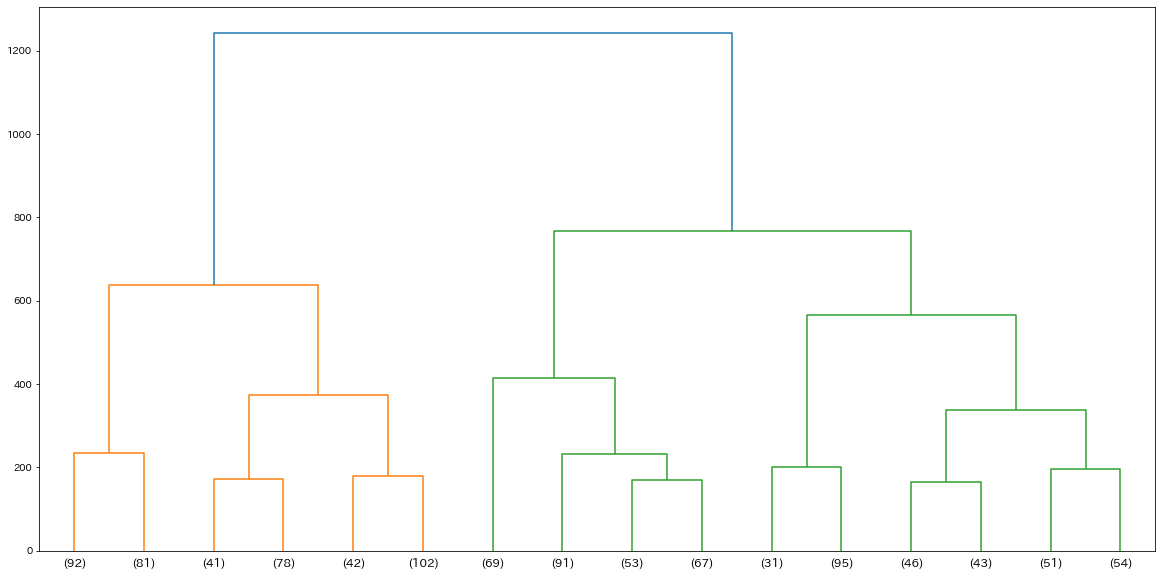

In [32]:
plt.figure(figsize=(20, 10))
# d = dendrogram(Z)
d = dendrogram(Z, truncate_mode='lastp', p=16)

In [35]:
d

{'icoord': [[5.0, 5.0, 15.0, 15.0],
  [25.0, 25.0, 35.0, 35.0],
  [10.0, 10.0, 30.0, 30.0]],
 'dcoord': [[0.0, 637.5962702783387, 637.5962702783387, 0.0],
  [0.0, 768.020515921608, 768.020515921608, 0.0],
  [637.5962702783387, 1242.299304435176, 1242.299304435176, 768.020515921608]],
 'ivl': ['(173)', '(263)', '(280)', '(320)'],
 'leaves': [2063, 2065, 2066, 2067],
 'color_list': ['C1', 'C2', 'C0'],
 'leaves_color_list': ['C1', 'C1', 'C2', 'C2']}

## sklearn.cluster.AgglomerativeClustering

In [34]:
dtw_clustering = AgglomerativeClustering(linkage='average', metric='precomputed', compute_distances=True)
dtw_labels = dtw_clustering.fit_predict(p)

In [37]:
np.unique(dtw_labels)

array([0, 1])

In [36]:
# dendrogram描画-sklearnのサイトにあるもの
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

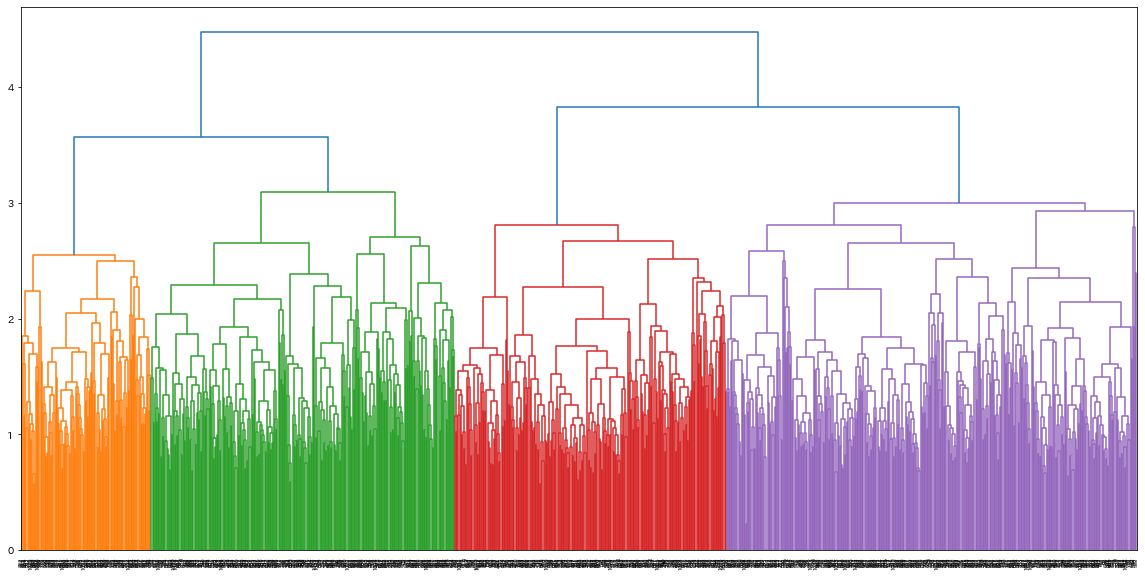

In [38]:
plt.figure(figsize=(20, 10))
plot_dendrogram(dtw_clustering)